# A sample small data analysis


In [1]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from random import shuffle
from Bio.Align.Applications import MuscleCommandline
from Bio import AlignIO
from include import *
import itertools
import operator
import time

In [2]:
# Read data
orig_seqs = file_to_list("data/File1_ODNA.txt")
filename = "data/I16_S2_R1_001.fastq"
seqs = fastq_to_list(filename)

In [3]:
print("all sequences: ", len(seqs))
print("all orig sequences: ", len(orig_seqs))
seqs = [seq for seq in seqs if len(seq) >= 55 and len(seq) <= 65]
print("all long sequences: ",  len(seqs))
# random sample the space
sample_size = int(5e6)
indeces = np.ndarray.tolist(np.random.randint(0,len(seqs),size=(1,sample_size)))[0]
seqs = [seqs[i] for i in indeces]

all sequences:  29303855
all orig sequences:  16383
all long sequences:  11083592


In [4]:
def fraction_recovered(candidates,orig_seqs):
    d = {}
    for seq in orig_seqs:
        d[seq] = 0
    for cand in candidates:
        if cand in d:
            d[cand] += 1
    av = sum([ d[seq]>0 for seq in d]) / len(d)
    print("Fraction of recovered sequences: ", av )
    if av>0:
        print("Fraction of recovered sequences: ", sum([ d[seq] for seq in d]) / len(d) / av )

In [5]:
def errorprob(candidates,orig_seqs):
    ctr = 0
    d = {}
    for seq in orig_seqs:
        d[seq] = 0
    for cand in candidates:
        if cand in d:
            ctr += 1
    print("Fraction of error free sequences: ", ctr/len(candidates) )

length distribution nucleotides:


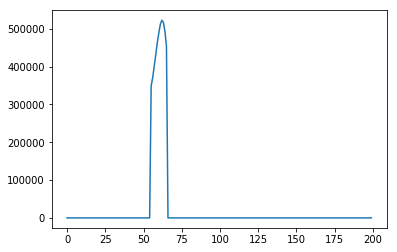

In [6]:
l, nuc, n =  seq_stats(seqs)
print("length distribution nucleotides:")
plt.plot(l)
plt.show()

## True Clustering
Finding true clusters to work on a few number of them

We first randomly choose 500 centers and find close ones to each one from the 5,000,000 sequences we randomly chose from the main sequences

In [7]:
inds = np.random.permutation(len(orig_seqs))
originals = []
for ind in inds:
    originals += [orig_seqs[ind]]
    if len(originals) == 500:
        break

true_clusters = []
pool = []
nbeg = 10
for i,orig in enumerate(originals):
    cluster = []
    for seq in seqs:
        if seq[:nbeg]==orig[:nbeg]:
            cluster += [seqs.index(seq)]
            pool += [seq]
    if i%50==0:
        print("%",i*100/len(originals))
    true_clusters += [cluster]

% 0.0
% 10.0
% 20.0
% 30.0
% 40.0
% 50.0
% 60.0
% 70.0
% 80.0
% 90.0


## pool size and number of centers

In [8]:
print(len(pool))
print(len(originals))

28225
500


## distribution of reads per center

#reads/center distribution plot (this plot is implortant because 
 we get to know how well a cluster and hence a center can be recovered)


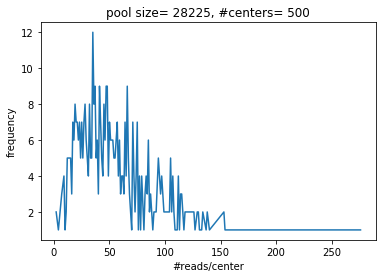

#true_clusters with length <= 5 is 3
#true_clusters with length <= 6 is 3
#true_clusters with length <= 7 is 6
#true_clusters with length <= 8 is 6
#true_clusters with length <= 9 is 10

clusters with len<=9 are unlikely to be recovered,
in that the algorithm can't find all elements of a
cluster and hence majority merging won't possibly work (based on the runs I saw)


In [11]:
print("#reads/center distribution plot (this plot is implortant because \n we get to\
 know how well a cluster and hence a center can be recovered)")
l = {}
for c in true_clusters:
    if len(c) in l:
        l[len(c)] += 1
    else:
        l[len(c)] = 1
l = list(l.items())
l.sort()
l = dict(l)
plt.plot(list(l.keys()),list(l.values()))
plt.title("pool size= "+str(len(pool))+", "+"#centers= "+str(len(originals)))
plt.ylabel("frequency")
plt.xlabel("#reads/center")
plt.show()

for i in range(5,10):
    ctr = 0
    for c in true_clusters:
        if len(c)<=i:
            ctr += 1
    print("#true_clusters with length <=",i,"is",ctr)
print("\nclusters with len<=9 are unlikely to be recovered,\nin that the algorithm can't find all elements\
 of a\ncluster and hence majority merging won't\
 possibly work (based on the runs I saw)")

## similarity analysis for within/between two sample clusters 
take 1st and 2nd true cluster and compute jaccard similarity for within/between them

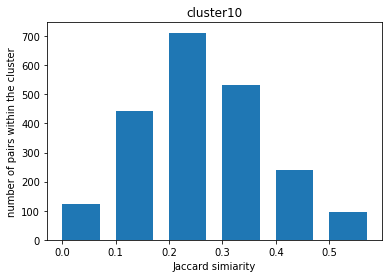

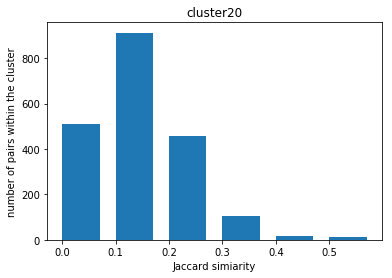

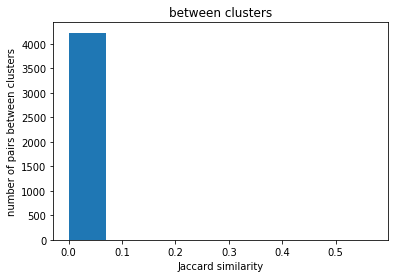

In [12]:
ind = [10,20]
# within each cluster
for i in ind:
    w_jac_ctr = {0:0,0.1:0,0.2:0,0.3:0,0.4:0,0.5:0}
    c = true_clusters[i]
    for j in range(len(c)):
        for k in range(j+1,len(c)):
            kmer0 = set( kmerDNA(seqs[c[j]],6) ) # shingle size is 6
            kmer1 = set( kmerDNA(seqs[c[k]],6) ) # shingle size is 6
            jac = len(kmer0.intersection(kmer1))/len(kmer0.union(kmer1))
            if jac<0.1:
                w_jac_ctr[0] += 1
            elif 0.1<=jac<0.2:
                w_jac_ctr[0.1] += 1
            elif 0.2<=jac<0.3:
                w_jac_ctr[0.2] += 1
            elif 0.3<=jac<0.4:
                w_jac_ctr[0.3] += 1
            elif 0.4<=jac<0.5:
                w_jac_ctr[0.4] += 1
            else:
                w_jac_ctr[0.5] += 1
    plt.bar(list(w_jac_ctr.keys()),list(w_jac_ctr.values()),width=0.07,align='edge')
    plt.xlabel("Jaccard simiarity")
    plt.ylabel("number of pairs within the cluster")
    plt.title("cluster"+str(i))
    plt.show()
# between two clusters
b_jac_ctr = {0:0,0.1:0,0.2:0,0.3:0,0.4:0,0.5:0}
c0 = true_clusters[ind[0]]
c1 = true_clusters[ind[1]]
for j in c0:
    for k in c1:
        kmer0 = set( kmerDNA(seqs[j],6) )
        kmer1 = set( kmerDNA(seqs[k],6) )
        jac = len(kmer0.intersection(kmer1))/len(kmer0.union(kmer1))
        if jac<0.1:
            b_jac_ctr[0] += 1
        elif 0.1<=jac<0.2:
            b_jac_ctr[0.1] += 1
        elif 0.2<=jac<0.3:
            b_jac_ctr[0.2] += 1
        elif 0.3<=jac<0.4:
            b_jac_ctr[0.3] += 1
        elif 0.4<=jac<0.5:
            b_jac_ctr[0.4] += 1
        else:
            b_jac_ctr[0.5] += 1
plt.bar(list(b_jac_ctr.keys()),list(b_jac_ctr.values()),width=0.07,align='edge')
plt.xlabel("Jaccard similarity")
plt.ylabel("number of pairs between clusters")
plt.title("between clusters")
plt.show()

## Clustering 


In [13]:
#===== assign numbers to shingles of each sequence=====#
def kmerDNA(seq,k=3):
    kmer = []
    for ell in range(len(seq)-k+1):
        nstr = seq[ell:ell+k]
        index = 0
        for j,c in enumerate(nstr):
            if c == 'A':
                i = 0
            elif c == 'C':
                i = 1
            elif c == 'G':
                i = 2
            elif c == 'T':
                i = 3
            else:
                index = -1
                break
            index += i*(4**j)
        kmer += [index]
    return kmer
#=====min-hash object=====#
class minhashsig():
    # min-hash of k-mers
    def __init__(self,m,k):
        # m is the number of signatures
        self.tables = [np.random.permutation(4**k) for i in range(m)]
        self.k = k
    def generate_signature(self,seq):
        kmer = kmerDNA(seq,self.k)
        sig = [ min([table[i] for i in kmer]) for table in self.tables]
        return sig
#=====pair detection=====#
def extract_similar_pairs(sigs,m,k_lsh,ell_lsh,maxsig):
    # sigs: minhash signatures
    # ell_lsh: number of LSH signatures
    # k_lsh: number of MH signatures to be concatenated
    
    #pairs = set([])
    
    # generate ell_lsh random indices
    for ell in range(ell_lsh):
        pairs = set([])
        lshinds = np.random.permutation(m)[:k_lsh]
        # generate LSh signatures
        lshsigs = []
        for sig in sigs:
            lshsig = 0
            for i,lshind in enumerate(lshinds):
                lshsig += sig[lshind]*(maxsig**i)
            lshsigs += [lshsig]
        d = {}
        for ind,sig in enumerate(lshsigs):
            if sig in d:
                d[sig] += [ind]
            else:
                d[sig] = [ind]
        for candidates in d.values():
            if len(candidates) > 1:
                for pair in itertools.combinations(candidates,2):
                    pairs.add(pair)
        yield pairs
    #return pairs
#=====form clusters based on pairs=====#
def center_cluster(pairs,L):
    clusters = {}
    hold = 0
    counter = 0
    vals = []
    pairsize = 0
    while hold==0:
        
        try:
            s = time.time()
            pairs_sort = list(next(pairs))
            print("Pair Extraction time for LSH",counter,":",time.time()-s,"---","#pairs:",len(pairs_sort))
            #s = time.time()
            #pairs_sort.sort()
            #print("Pair Sorting time for LSH",counter,":",time.time()-s)
        
            s = time.time()
            for (u,v) in pairs_sort:
                if u in clusters:
                    clusters[u] += [v]
                    #if v not in vals and v not in clusters:
                        #clusters[u] += [v]
                        #vals += [v]
        
                if v in clusters:
                    clusters[v] += [u]
                    #if u not in vals and u not in clusters:
                        #clusters[v] += [u]
                        #vals += [u]
        
                if v not in clusters and u not in clusters:
                    clusters[u] = [v]
                    #if v not in vals and u not in vals:
                        #clusters[u] = [v]
                        #vals += [v]
            print("Clustering time for LSH",counter,":",time.time()-s,'\n')
            pairsize += len(pairs_sort)
        except StopIteration:
            hold = 1
            print("level_1 clustering finished","---",pairsize,"pairs extracted")
        counter += 1
    # remove repeated ones
    for d in clusters:
        clusters[d] = list(set(clusters[d]))
    list_clusters = clusters   
    #list_clusters = []
    #for d in clusters:
        #list_clusters += [ [d]+clusters[d] ]
        
    # find a cluster for each of the left-outs
    #left_outs = []
    #for i in range(L):
        #if i not in vals and i not in clusters:
            #left_outs += [i]
    #for index in left_outs:
        #flag = 0
        #c = -1
        #for (u,v) in pairs_sort:
            #if u == index:
                #flag = 1
                #c = v
                #break
            #elif v == index:
                #flag = 1
                #c = u
                #break
        #if flag == 1:
            #for j in range(len(list_clusters)):
                #if c in list_clusters[j]:
                    #list_clusters[j] += [index]
                    #break
    #print("level_2 clustering finished")
    return list_clusters
#=====max matching=====#
def max_match(seq1,seq2):
    alignment,score,start_end_positions \
        = local_pairwise_align_ssw(DNA(seq1) , DNA(seq2) , match_score=2,mismatch_score=-3)
    a = str(alignment[0])
    b = str(alignment[1])
    ctr = 0
    for i,j in zip(a,b):
        if i==j:
            ctr += 1
    return ctr
#=====filter pairs=====#
def filter_pairs(pairs,seqs,maxmatch=40):
    filtered_pairs =[]
    hold = 0
    counter = 0
    while hold ==0:
        try:
            s = time.time()
            pairset = next(pairs)
            print("(MAXMATCH)Pair Extraction time for LSH",counter,":",time.time()-s,len(pairset))
            s = time.time()
            for (u,v) in pairset:
                score = max_match( seqs[u] , seqs[v] )
                if score>=maxmatch:
                    filtered_pairs += [(u,v)]
            print("filtering these pairs takes:",time.time()-s,len(filtered_pairs))
            counter += 1
            yield filtered_pairs
        except StopIteration:
            hold = 1
            yield [(0,0)]
    #return filtered_pairs
#=====LSH clustering (main function)=====#
def lsh_cluster(seqs,m,k,k_lsh=2,ell_lsh=4,maxmatch=10):
    s = time.time()
    minhash = minhashsig(m,k)
    sigs = [minhash.generate_signature(seq[:20]) for seq in seqs]
    print("MH time:",time.time()-s)
    maxsig = 4**k
    pairs = extract_similar_pairs(sigs,m,k_lsh,ell_lsh,maxsig)
    if maxmatch>0:
        f_pairs = filter_pairs(pairs,seqs,maxmatch)
        clusters = center_cluster(f_pairs,len(seqs))
    else:
        clusters = center_cluster(pairs,len(seqs))
    return clusters

In [14]:
k,m,k_lsh = 7,50,4
sim=0.25
ell_lsh = int((1/sim)**k_lsh)
maxmatch = 0

start = time.time()
clusters = lsh_cluster(pool,m,k,k_lsh,ell_lsh,maxmatch)
end = time.time()

print("Runtime:",end-start)
len(clusters)

MH time: 3.957923173904419
Pair Extraction time for LSH 0 : 0.3818061351776123 --- #pairs: 130719
Clustering time for LSH 0 : 0.05400991439819336 

Pair Extraction time for LSH 1 : 0.409360408782959 --- #pairs: 137111
Clustering time for LSH 1 : 0.09124159812927246 

Pair Extraction time for LSH 2 : 0.1346273422241211 --- #pairs: 131143
Clustering time for LSH 2 : 0.08130431175231934 

Pair Extraction time for LSH 3 : 0.13388824462890625 --- #pairs: 129871
Clustering time for LSH 3 : 0.0785684585571289 

Pair Extraction time for LSH 4 : 0.4141824245452881 --- #pairs: 133238
Clustering time for LSH 4 : 0.0816648006439209 

Pair Extraction time for LSH 5 : 0.1411149501800537 --- #pairs: 140469
Clustering time for LSH 5 : 0.08714914321899414 

Pair Extraction time for LSH 6 : 0.1420137882232666 --- #pairs: 133526
Clustering time for LSH 6 : 0.08341002464294434 

Pair Extraction time for LSH 7 : 0.4234955310821533 --- #pairs: 138447
Clustering time for LSH 7 : 0.08629035949707031 

Pair Ex

Clustering time for LSH 66 : 0.09113240242004395 

Pair Extraction time for LSH 67 : 0.13843441009521484 --- #pairs: 136505
Clustering time for LSH 67 : 0.09037160873413086 

Pair Extraction time for LSH 68 : 0.14173507690429688 --- #pairs: 134588
Clustering time for LSH 68 : 0.08970117568969727 

Pair Extraction time for LSH 69 : 0.7300758361816406 --- #pairs: 128771
Clustering time for LSH 69 : 0.08713340759277344 

Pair Extraction time for LSH 70 : 0.13669562339782715 --- #pairs: 136358
Clustering time for LSH 70 : 0.09009361267089844 

Pair Extraction time for LSH 71 : 0.1403207778930664 --- #pairs: 131196
Clustering time for LSH 71 : 0.08624935150146484 

Pair Extraction time for LSH 72 : 0.7484683990478516 --- #pairs: 132938
Clustering time for LSH 72 : 0.08801627159118652 

Pair Extraction time for LSH 73 : 0.1412794589996338 --- #pairs: 133717
Clustering time for LSH 73 : 0.08987116813659668 

Pair Extraction time for LSH 74 : 0.1416466236114502 --- #pairs: 139225
Clustering ti

Clustering time for LSH 133 : 0.0974740982055664 

Pair Extraction time for LSH 134 : 0.14178180694580078 --- #pairs: 136825
Clustering time for LSH 134 : 0.09342479705810547 

Pair Extraction time for LSH 135 : 1.120575189590454 --- #pairs: 135111
Clustering time for LSH 135 : 0.09200406074523926 

Pair Extraction time for LSH 136 : 0.1426239013671875 --- #pairs: 132354
Clustering time for LSH 136 : 0.08941507339477539 

Pair Extraction time for LSH 137 : 0.139556884765625 --- #pairs: 132726
Clustering time for LSH 137 : 0.08873414993286133 

Pair Extraction time for LSH 138 : 1.1379344463348389 --- #pairs: 134025
Clustering time for LSH 138 : 0.09042239189147949 

Pair Extraction time for LSH 139 : 0.14132189750671387 --- #pairs: 134086
Clustering time for LSH 139 : 0.08981823921203613 

Pair Extraction time for LSH 140 : 0.13932156562805176 --- #pairs: 134495
Clustering time for LSH 140 : 0.0891563892364502 

Pair Extraction time for LSH 141 : 1.1536896228790283 --- #pairs: 131536
C

Clustering time for LSH 199 : 0.09291481971740723 

Pair Extraction time for LSH 200 : 0.14288997650146484 --- #pairs: 127138
Clustering time for LSH 200 : 0.08868765830993652 

Pair Extraction time for LSH 201 : 1.5290770530700684 --- #pairs: 131084
Clustering time for LSH 201 : 0.09367918968200684 

Pair Extraction time for LSH 202 : 0.1444251537322998 --- #pairs: 139895
Clustering time for LSH 202 : 0.09100461006164551 

Pair Extraction time for LSH 203 : 0.1356515884399414 --- #pairs: 129556
Clustering time for LSH 203 : 0.0881047248840332 

Pair Extraction time for LSH 204 : 1.5394935607910156 --- #pairs: 136745
Clustering time for LSH 204 : 0.09234404563903809 

Pair Extraction time for LSH 205 : 0.1363992691040039 --- #pairs: 132324
Clustering time for LSH 205 : 0.08920693397521973 

Pair Extraction time for LSH 206 : 0.14010238647460938 --- #pairs: 134741
Clustering time for LSH 206 : 0.09024381637573242 

Pair Extraction time for LSH 207 : 1.560668706893921 --- #pairs: 135262


25873

### Find a cluster that recovers a center

In [21]:
#clusters = list(clusters.values())
for n in range(10):
    seqss = [pool[i] for i in clusters[n]]
    ma = multiple_alignment(seqss)
    out = majority_merge(ma)
    print("Is output of cluster",n,"a recovered center?",out[:60] in originals)
    if out[:60] in originals:
        cind = n

Is output of cluster 0 a recovered center? False
Is output of cluster 1 a recovered center? False
Is output of cluster 2 a recovered center? False
Is output of cluster 3 a recovered center? True
Is output of cluster 4 a recovered center? False
Is output of cluster 5 a recovered center? False
Is output of cluster 6 a recovered center? False
Is output of cluster 7 a recovered center? True
Is output of cluster 8 a recovered center? False
Is output of cluster 9 a recovered center? True


## Analyze this chosen cluster

In [22]:
n = cind
counters = {0:0,0.1:0,0.2:0,0.3:0,0.4:0,0.5:0}
for i in range(len(clusters[n])):
    for j in range(i+1,len(clusters[n])):
        kmer0 = set(kmerDNA(pool[clusters[n][i]],7))
        kmer1 = set(kmerDNA(pool[clusters[n][j]],7))
        jac = len(kmer0.intersection(kmer1))/len(kmer0.union(kmer1))
        if jac>=0.5:
            counters[0.5] += 1
        elif 0.4<=jac<0.5:
            counters[0.4] += 1
        elif 0.3<=jac<0.4:
            counters[0.3] += 1
        elif 0.2<=jac<0.3:
            counters[0.2] += 1
        elif 0.1<=jac<0.2:
            counters[0.1] += 1
        else:
            counters[0] += 1

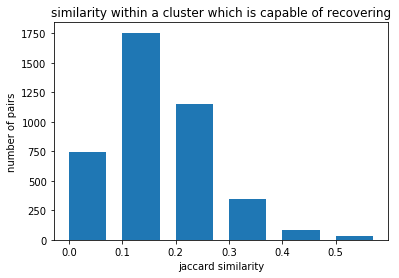

{0: 743, 0.1: 1754, 0.2: 1146, 0.3: 342, 0.4: 80, 0.5: 30}


In [23]:
plt.bar(list(counters.keys()),list(counters.values()),width=0.07,align='edge')
plt.xlabel('jaccard similarity')
plt.ylabel('number of pairs')
plt.title('similarity within a cluster which is capable of recovering')
plt.show()
print(counters)

In [24]:
results = []
#clusters = list(clusters.values())
def align_clusters(clusters,masize = 15):
    ### align clusters, generate candidates
    for i, clusterinds in enumerate(clusters):
        cluster = [pool[i] for i in clusterinds]
        if len(cluster)<=4:
            continue
        ma = multiple_alignment(cluster)
        results.append(ma)
            
        if i % 10 == 0:
            print(i/len(clusters))
            #fraction_recovered( [seq[:60] for seq in results] , originals)
s = time.time()
align_clusters(clusters)
print("Alignment Runtime:",time.time()-s)

0.0
0.00038650330460325436
0.0007730066092065087
0.001159509913809763
0.0015460132184130174
0.0019325165230162718
0.002319019827619526
0.0027055231322227805
0.003092026436826035
0.0034785297414292892
0.0038650330460325436
0.0042515363506357975
0.004638039655239052
0.005024542959842306
0.005411046264445561
0.005797549569048815
0.00618405287365207
0.006570556178255324
0.0069570594828585785
0.007343562787461832
0.007730066092065087
0.008116569396668341
0.008503072701271595
0.00888957600587485
0.009276079310478105
0.009662582615081359
0.010049085919684612
0.010435589224287868
0.010822092528891122
0.011208595833494376
0.01159509913809763
0.011981602442700886
0.01236810574730414
0.012754609051907393
0.013141112356510647
0.013527615661113903
0.013914118965717157
0.01430062227032041
0.014687125574923665
0.01507362887952692
0.015460132184130174
0.01584663548873343
0.016233138793336682
0.016619642097939938
0.01700614540254319
0.017392648707146446
0.0177791520117497
0.018165655316352954
0.0185521

0.1592393614965408
0.15962586480114405
0.16001236810574732
0.16039887141035056
0.1607853747149538
0.16117187801955707
0.1615583813241603
0.16194488462876358
0.16233138793336682
0.1627178912379701
0.16310439454257333
0.1634908978471766
0.16387740115177984
0.16426390445638311
0.16465040776098636
0.1650369110655896
0.16542341437019287
0.1658099176747961
0.16619642097939938
0.16658292428400262
0.1669694275886059
0.16735593089320913
0.1677424341978124
0.16812893750241564
0.1685154408070189
0.16890194411162215
0.1692884474162254
0.16967495072082867
0.1700614540254319
0.17044795733003518
0.17083446063463842
0.1712209639392417
0.17160746724384493
0.1719939705484482
0.17238047385305144
0.1727669771576547
0.17315348046225795
0.1735399837668612
0.17392648707146446
0.1743129903760677
0.17469949368067098
0.17508599698527422
0.1754725002898775
0.17585900359448073
0.176245506899084
0.17663201020368724
0.1770185135082905
0.17740501681289375
0.177791520117497
0.17817802342210026
0.1785645267267035
0.17

0.3231167626483206
0.3235032659529239
0.32388976925752716
0.32427627256213043
0.32466277586673364
0.3250492791713369
0.3254357824759402
0.3258222857805434
0.32620878908514667
0.32659529238974994
0.3269817956943532
0.3273682989989564
0.3277548023035597
0.32814130560816296
0.32852780891276623
0.32891431221736944
0.3293008155219727
0.329687318826576
0.33046032543578246
0.33084682874038573
0.331233332044989
0.3316198353495922
0.3320063386541955
0.33239284195879876
0.332779345263402
0.33316584856800524
0.3335523518726085
0.3339388551772118
0.334325358481815
0.33471186178641826
0.33509836509102153
0.3354848683956248
0.335871371700228
0.3362578750048313
0.33664437830943456
0.3370308816140378
0.33741738491864104
0.3378038882232443
0.3381903915278476
0.3385768948324508
0.33896339813705406
0.33934990144165733
0.3397364047462606
0.3401229080508638
0.3405094113554671
0.34089591466007035
0.3412824179646736
0.34166892126927684
0.3420554245738801
0.3424419278784834
0.3428284311830866
0.34360143779229

0.4947242298921656
0.49511073319676885
0.49549723650137206
0.49588373980597533
0.4962702431105786
0.49665674641518187
0.4970432497197851
0.49742975302438835
0.4978162563289916
0.4982027596335949
0.4985892629381981
0.4989757662428014
0.49936226954740465
0.49974877285200786
0.5001352761566111
0.5005217794612143
0.5009082827658177
0.5012947860704209
0.5016812893750242
0.5020677926796274
0.502840799288834
0.5032273025934372
0.5036138058980404
0.5040003092026437
0.5043868125072469
0.5051598191164535
0.5055463224210567
0.50593282572566
0.5063193290302632
0.5067058323348664
0.5070923356394698
0.507478838944073
0.5078653422486762
0.5082518455532795
0.5086383488578827
0.5090248521624859
0.5094113554670893
0.5097978587716925
0.5101843620762958
0.510570865380899
0.5109573686855022
0.5113438719901056
0.5117303752947088
0.512116878599312
0.5125033819039153
0.5128898852085185
0.5132763885131217
0.5136628918177251
0.5140493951223283
0.5144358984269316
0.5148224017315348
0.515208905036138
0.5155954083

0.6678777103544236
0.6682642136590268
0.66865071696363
0.6690372202682333
0.6694237235728365
0.6698102268774399
0.6701967301820431
0.6705832334866463
0.6709697367912496
0.6713562400958528
0.671742743400456
0.6721292467050594
0.6725157500096626
0.6729022533142658
0.6732887566188691
0.6736752599234723
0.6740617632280756
0.6744482665326789
0.6748347698372821
0.6752212731418854
0.6756077764464886
0.6759942797510918
0.6763807830556952
0.6767672863602984
0.6771537896649016
0.6775402929695049
0.6779267962741081
0.6783132995787114
0.6786998028833147
0.6790863061879179
0.6794728094925212
0.6798593127971244
0.6802458161017276
0.680632319406331
0.6810188227109342
0.6814053260155374
0.6817918293201407
0.6821783326247439
0.6825648359293472
0.6829513392339505
0.6833378425385537
0.683724345843157
0.6841108491477602
0.6844973524523634
0.6848838557569668
0.68527035906157
0.6856568623661732
0.6860433656707765
0.6864298689753797
0.686816372279983
0.6872028755845863
0.6875893788891895
0.6879758821937928
0

0.8414176941212848
0.8421907007304913
0.8425772040350945
0.8429637073396977
0.843350210644301
0.8437367139489043
0.8441232172535075
0.844896223862714
0.8452827271673172
0.8456692304719206
0.8460557337765238
0.8464422370811271
0.8468287403857303
0.8472152436903335
0.8476017469949368
0.8479882502995401
0.8483747536041433
0.8491477602133498
0.849534263517953
0.8499207668225564
0.8503072701271596
0.8506937734317629
0.8510802767363661
0.8514667800409693
0.8518532833455726
0.8522397866501759
0.8526262899547791
0.8530127932593824
0.8533992965639856
0.8537857998685888
0.8541723031731921
0.8545588064777954
0.8549453097823987
0.8553318130870019
0.8557183163916051
0.8561048196962084
0.8564913230008117
0.8568778263054149
0.8572643296100182
0.8576508329146214
0.8580373362192246
0.858423839523828
0.8588103428284312
0.8591968461330345
0.8595833494376377
0.8599698527422409
0.8603563560468442
0.8607428593514475
0.8611293626560507
0.861515865960654
0.8619023692652572
0.8622888725698604
0.862675375874463

In [25]:
def majority_merge(reads,weight = 0.4):
    # assume reads have the same lenght
    res = ""
    for i in range(len(reads[0])):
        counts = {'A':0,'C':0,'G':0,'T':0,'-':0,'N':0}
        for j in range(len(reads)):
            counts[reads[j][i]] +=1
        counts['-'] *= weight
        mv = max(counts.items(), key=operator.itemgetter(1))[0]
        if mv != '-':
            res += mv
    return res

candidates = []
for ma in results:
    candidates.append(majority_merge(ma,weight=0.5)) # 0.45
fraction_recovered( [seq[:60] for seq in candidates] , originals)

Fraction of recovered sequences:  0.618
Fraction of recovered sequences:  25.06148867313916


In [26]:
len(candidates)

24844

## Recovery Analysis (Just the length of clusters)
Take original sequences that have been recovered. Count how many sequences they had in their true clusters. 
I expect that most of them are the ones which had more than 15 or 20 members in their true clusters.

In [39]:
cands = [seq[:60] for seq in candidates]
for i,orig in enumerate(originals):
    if orig in cands:
        print("Original seq #",i,"has been recovered. #members in its true cluster:",len(true_clusters[i]))

Original seq # 0 has been recovered. #members in its true cluster: 15
Original seq # 2 has been recovered. #members in its true cluster: 53
Original seq # 4 has been recovered. #members in its true cluster: 36
Original seq # 8 has been recovered. #members in its true cluster: 108
Original seq # 9 has been recovered. #members in its true cluster: 118
Original seq # 10 has been recovered. #members in its true cluster: 66
Original seq # 11 has been recovered. #members in its true cluster: 140
Original seq # 13 has been recovered. #members in its true cluster: 69
Original seq # 14 has been recovered. #members in its true cluster: 79
Original seq # 15 has been recovered. #members in its true cluster: 83
Original seq # 16 has been recovered. #members in its true cluster: 40
Original seq # 17 has been recovered. #members in its true cluster: 75
Original seq # 19 has been recovered. #members in its true cluster: 131
Original seq # 20 has been recovered. #members in its true cluster: 64
Origina

The expectation was true!